In [1]:
%matplotlib widget
import numpy as np
import os
import sys
import data_processing as proc
import run_bpt as run
import cfl
import matplotlib.pyplot as plt
import sigpy as sp
import sigpy.plot as pl
import figure_plotting as fpl

# Registration tools
import SimpleITK as sitk

from scipy import signal

# Functions

In [13]:
def register_imgs(fixed_img, moving_img, rot_center, reg_outdir=None, debug=False, fixed_mask=None):
    ''' Register images with SimpleElastix rigid registration '''
    # perform registration and extract results
    ndyn = moving_img.shape[0]
    transform_parameters = np.zeros((ndyn, 3))
    result_img = np.zeros(moving_img.shape)
    fixed_img = sitk.GetImageFromArray(fixed_img)

    # because the top of the y-axis is negative, and the left of the x-axis is negative in the grid, the grid rotates around the point below, and not around the exact center point
    # WE NEED TO FLIP THE ORDERING OF ALL COORDINATES - ELASTIX HAS A DIFFERENT ARRAY ORDERING THAN NUMPY
    parameter_map = sitk.GetDefaultParameterMap('rigid')
    rot_center = np.flip(rot_center)
    parameter_map['CenterOfRotationPoint'] = [str(x) for x in rot_center]

    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_img)
    elastixImageFilter.SetParameterMap(parameter_map)

    # Set mask
    if fixed_mask is not None:
        sitk_img = sitk.GetImageFromArray(fixed_mask)
        elastixImageFilter.SetFixedMask(sitk.Cast(sitk_img, sitk.sitkUInt8))

    if not debug:
        elastixImageFilter.LogToConsoleOff()
    
    for i in range(ndyn):
        print("Performing registration for dynamic {}/{}...".format(i, ndyn-1))
        movim = sitk.GetImageFromArray(moving_img[i,...])
        elastixImageFilter.SetMovingImage(movim)
        elastixImageFilter.Execute()
        result_img[i,...] = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
        transform_parameters[i, :] = np.asarray([float(x) for x in elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"][:]])

    # Save results
    if reg_outdir is not None:
        np.save(os.path.join(reg_outdir,'transform_params.npy'), transform_parameters)
        np.save(os.path.join(reg_outdir, 'result_img.npy'), result_img)

    return result_img, transform_parameters


def plot_reg_results(transformParameters, res=2, figsize=(12,6)):
    ''' Plot image registration results '''
    fig, ax = plt.subplots(1,2, figsize=figsize)
    fig.suptitle('Bulk motion estimates')
    ax[0].plot(transformParameters[:, 0]/(2*np.pi)*360, '-o')
    ax[0].legend(['In-plane rotation (clockwise)'])
    ax[0].set_ylabel('Rotation angle [degrees]')
    ax[0].set_xlabel('Frame index')
    
    ax[1].plot(transformParameters[:, 1:]*res, '-o')
    ax[1].legend(['Translation horizontal (<-- = +)', 'Translation vertical (V = +)'])
    ax[1].set_ylabel('Displacement [mm]')
    ax[1].set_xlabel('Frame index')
    
    # for i in range(2):
        # ax[i].set_xlim(xlim)
        # ax[i].set_xticks(np.linspace(xlim[0], xlim[1], 5).astype(int))
    
    plt.show()

# Plots

In [3]:
plt.rcParams.update({'axes.spines.right':False,
                    'axes.spines.top':False,
                    'font.size': 14,
                    'axes.titlesize':14, # fontsize of the axes title
                    'axes.labelsize':14,
                    'axes.linewidth':2,
                    'legend.fontsize':12,
                    'xtick.labelsize':12,
                    'ytick.labelsize':12,
                    'lines.linewidth':2
                    })

In [4]:
# Load images
inpdir = "./data/resp/"
ksp = np.squeeze(cfl.readcfl(os.path.join(inpdir,"ksp")))

# Get image and crop
crop_win = 30
img = sp.ifft(ksp, axes=(0,1))
img_crop = img[crop_win:-crop_win,...]
img_crop_rss = np.rot90(sp.rss(img_crop, axes=(-1,)),3) # Rotate so chest is facing up

In [6]:
# Register images
# Define first image as the one to register to
fixed_img = img_crop_rss[...,0]
moving_img = img_crop_rss.transpose([-1,0,1])[72:88,...] # Manually select indices of bulk motion
cntr = np.array(img_crop.shape[1:])//2

# Do the registration with SimpleElastix
result_img, transform_params = register_imgs(fixed_img, moving_img,
                                        rot_center=cntr,
                                        reg_outdir=os.path.join(inpdir, "reg"),
                                        debug=False,
                                        fixed_mask=None)

Performing registration for dynamic 0/15...
Performing registration for dynamic 1/15...
Performing registration for dynamic 2/15...
Performing registration for dynamic 3/15...
Performing registration for dynamic 4/15...
Performing registration for dynamic 5/15...
Performing registration for dynamic 6/15...
Performing registration for dynamic 7/15...
Performing registration for dynamic 8/15...
Performing registration for dynamic 9/15...
Performing registration for dynamic 10/15...
Performing registration for dynamic 11/15...
Performing registration for dynamic 12/15...
Performing registration for dynamic 13/15...
Performing registration for dynamic 14/15...
Performing registration for dynamic 15/15...


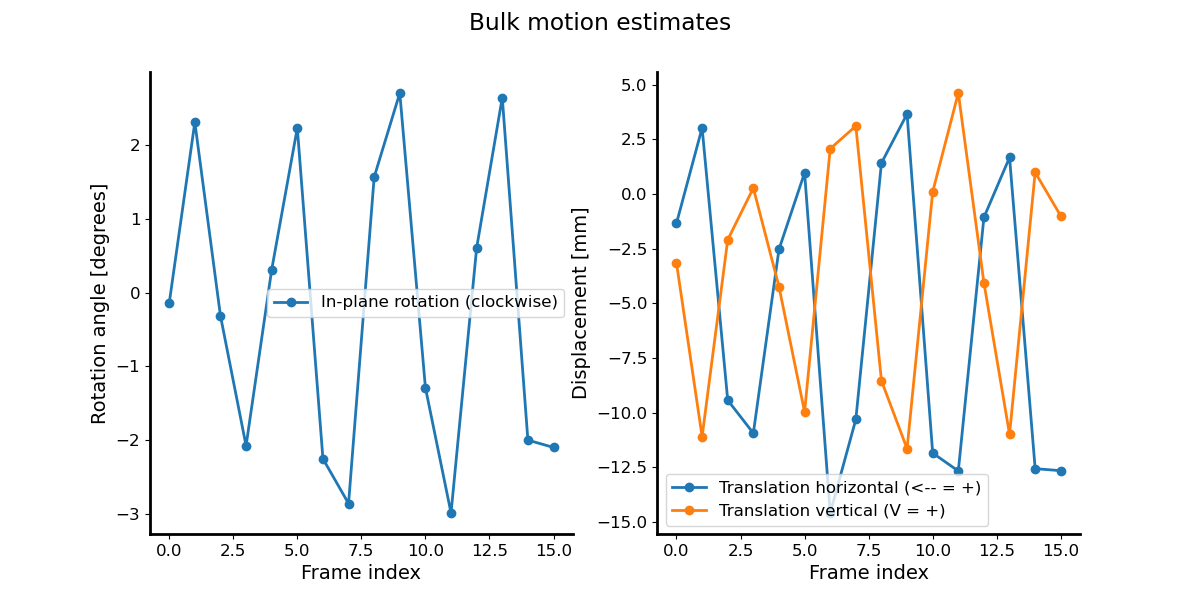

In [14]:
# Plot translation and rotation
plot_reg_results(transform_params, res=1.9, figsize=(12,6))
plt.subplots_adjust(bottom=0.15, wspace=0.3, hspace=0.2)
plt.savefig("bulk_motion_params.png", dpi=300, transparent=True)

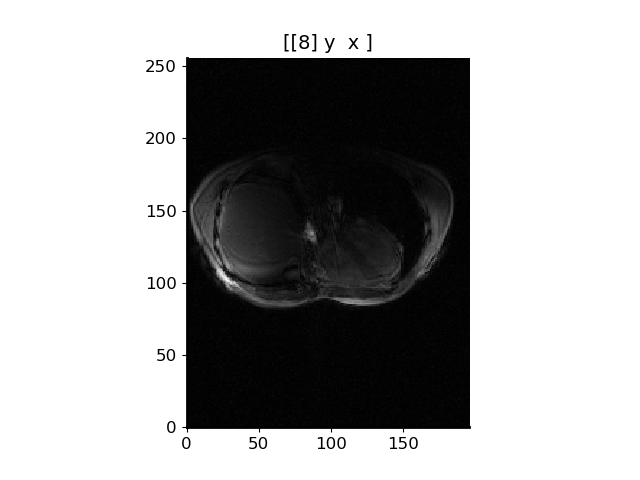

In [21]:
# Plot images
plt.rcParams.update({})
pl.ImagePlot(moving_img)

In [85]:
# Compare to BPT and PT
# Get percent mod in mag and phase
inpdir = os.path.join("./data","resp")
ref_coil = 0
tr = 4.4e-3
threshold = 0.2 # For extracting PT
cutoff = 14 # Hz

# Load PT obj mag, phase, and modulation
fb_2400 = run.load_bpt_mag_phase(inpdir, tr=tr, ref_coil=ref_coil,
                                 threshold=threshold, lpfilter=True,
                                 cutoff=cutoff)

PT exists! Reading file ./data/resp/pt_ravel.cfl


(80.0, 97.0)

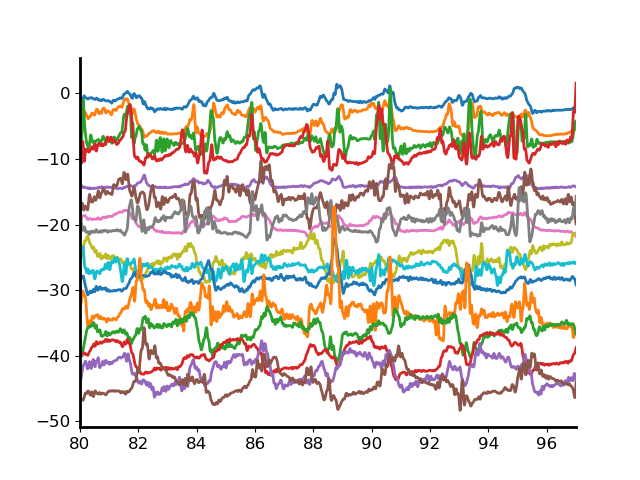

In [90]:
bpt = fb_2400.pt_mag_filtered[0,...]
shift = -3

plt.figure()
plt.plot(t, proc.normalize_c(bpt) + np.arange(bpt.shape[-1])*shift)
plt.xlim([80,97])

In [99]:
bpt_resamp

(array([243.81085, 303.03522, 273.91733, 152.73537, 237.648  , 264.17783,
        247.66544, 165.7248 , 246.40376, 266.2395 , 279.6943 , 126.23866,
        290.7665 , 270.99213, 301.98694, 203.18338], dtype=float32),
 array([ 0.    ,  1.0626,  2.1252,  3.1878,  4.2504,  5.313 ,  6.3756,
         7.4382,  8.5008,  9.5634, 10.626 , 11.6886, 12.7512, 13.8138,
        14.8764, 15.939 ]))

In [107]:
print(t_frame)
print(t_resamp)

[80.     81.1264 82.2528 83.3792 84.5056 85.632  86.7584 87.8848 89.0112
 90.1376 91.264  92.3904 93.5168 94.6432 95.7696 96.896 ]
[79.9964 81.059  82.1216 83.1842 84.2468 85.3094 86.372  87.4346 88.4972
 89.5598 90.6224 91.685  92.7476 93.8102 94.8728 95.9354]


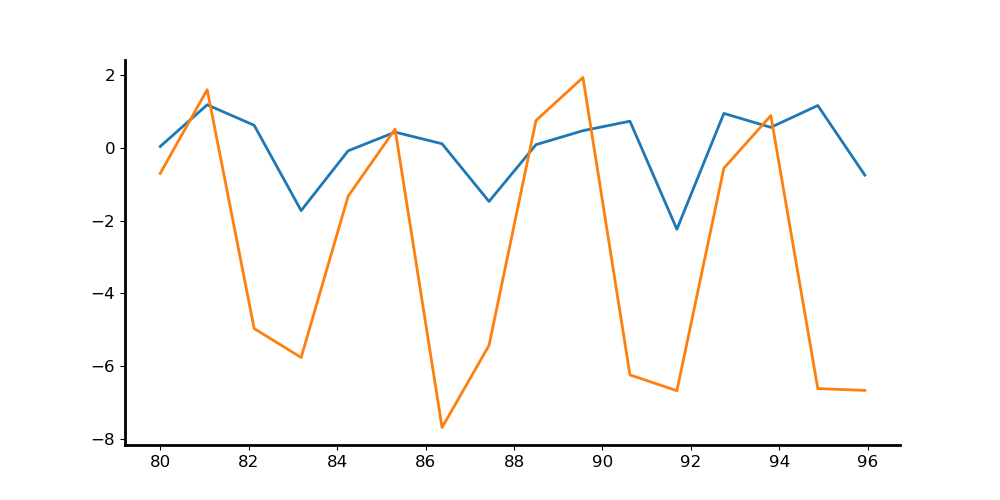

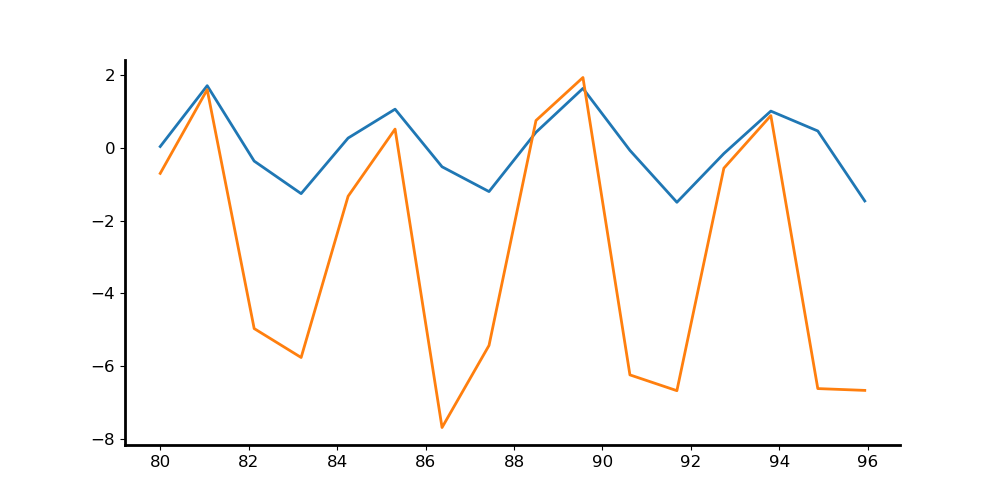

In [110]:
# Try resampling
c = [2,4]
for i in range(2): # BPT, PT
    # Select BPT/PT
    pt_plot = fb_2400.pt_mag_filtered[i,...]
    bpt_seg = pt_plot[n_start:n_end,c[i]]

    bpt_resamp, t_resamp = signal.resample(bpt_seg, len(transform_params), t=t[n_start:n_end])
    plt.figure(figsize=(10,5))
    plt.plot(t_resamp, proc.normalize(bpt_resamp))
    plt.plot(t_resamp, transform_params[:,1])

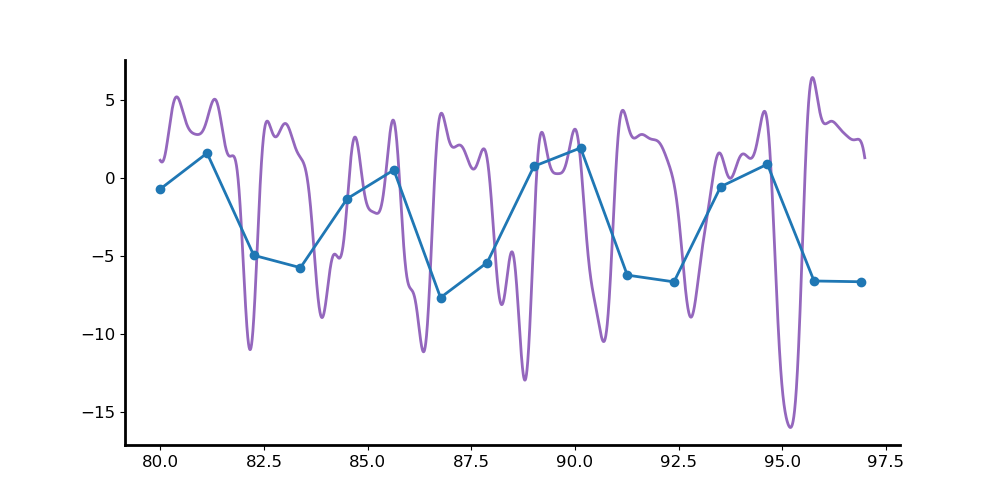

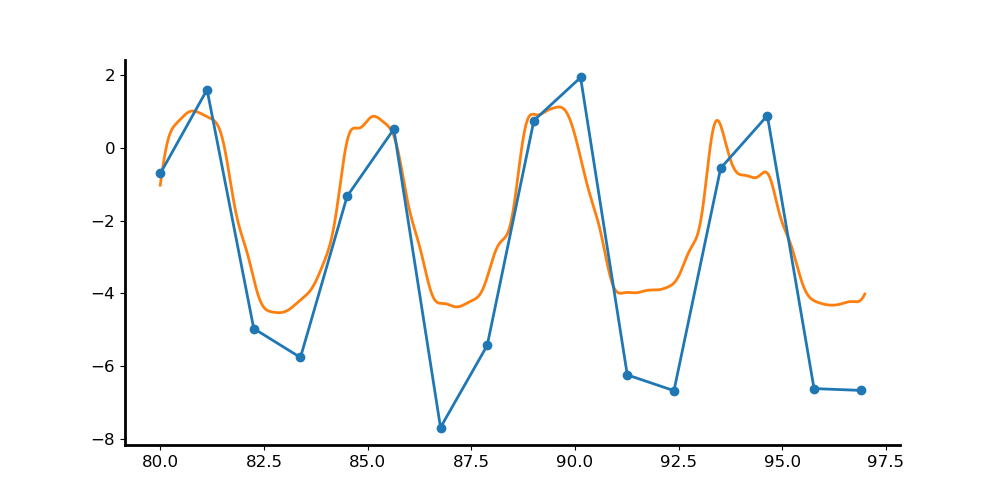

In [79]:
t = np.arange(bpt.shape[0])*tr
# Set plot limits
t_start, t_end = [80,97]
# plot_inds = [[2,4],[1,7]]
plot_inds = [[4],[1]]
n_start, n_end = [int(t_start/tr), int(t_end/tr)]

# Make color dictionary
bad_inds = np.array([10])
c_inds = np.delete(np.arange(16),bad_inds)
color_dict = fpl.make_color_dict(N=16)

# Sampling inds for time
t_frame = np.arange(len(transform_params))*tr*256 + t_start

scales = [-5,2]
shifts = [-1,-2]

for i in range(2): # BPT, PT
    plt.figure(figsize=(10,5))
    # plt.subplot(211)

    # Select BPT/PT
    pt_plot = fb_2400.pt_mag_filtered[i,...]
    coils = plot_inds[i]
    
    # Plot coils
    for c in coils:
        # pt_mod = (pt_plot[n_start:n_end,c] / np.mean(pt_plot[n_start:n_end,c], axis=0) - 1)*100
        pt_mod = proc.normalize(pt_plot[n_start:n_end,c]) * scales[i] + shifts[i]
        plt.plot(t[n_start:n_end], pt_mod, color=color_dict[c])

    plt.plot(t_frame, transform_params[:,1], '-o')